In [ ]:
!pip install opendatasets

In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
import opendatasets as od
import pandas

! kaggle datasets download aayush9753/image-colorization-dataset


Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 403, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
!unzip "/content/image-colorization-dataset.zip" -d "/content/dataset"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/data/train_color/image0000.jpg  
  inflating: /content/dataset/data/train_color/image0001.jpg  
  inflating: /content/dataset/data/train_color/image0002.jpg  
  inflating: /content/dataset/data/train_color/image0003.jpg  
  inflating: /content/dataset/data/train_color/image0004.jpg  
  inflating: /content/dataset/data/train_color/image0005.jpg  
  inflating: /content/dataset/data/train_color/image0006.jpg  
  inflating: /content/dataset/data/train_color/image0007.jpg  
  inflating: /content/dataset/data/train_color/image0008.jpg  
  inflating: /content/dataset/data/train_color/image0009.jpg  
  inflating: /content/dataset/data/train_color/image0010.jpg  
  inflating: /content/dataset/data/train_color/image0011.jpg  
  inflating: /content/dataset/data/train_color/image0012.jpg  
  inflating: /content/dataset/data/train_color/image0013.jpg  
  inflating: /content/dataset/data/train_color/image0014.jpg  
  in

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.color import rgb2lab, lab2rgb
from skimage.transform import resize
from skimage.io import imsave

import tensorflow as tf
from keras.layers import Conv2D, UpSampling2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

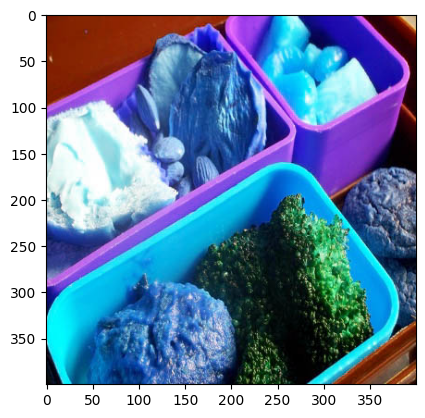

In [ ]:
import cv2

img =  cv2.imread('/content/dataset/data/train_color/image0000.jpg')
plt.imshow(img)

In [ ]:
train_dir = "../content/dataset/train_data/"

#Resize images
img_width = 224
img_height = 224
image_size = (img_width, img_height)


In [ ]:
train_datagen = ImageDataGenerator(
        rotation_range=15,
        rescale=1./255,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        featurewise_center=True)

train = train_datagen.flow_from_directory(batch_size=128,
                                                     directory=train_dir,
                                                     target_size=image_size,
                                                      color_mode = "rgb",
                                                     class_mode=None)

Found 5000 images belonging to 1 classes.


In [ ]:
X = []
y = []
for img in train[0]:
  try:
    lab = rgb2lab(img)
    X.append(lab[:,:,0])
    y.append(lab[:,:,1:] / 128)
  except:
    print('error')

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1862: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


In [ ]:
X = np.array(X)
y = np.array(y)

X = X.reshape(X.shape+(1,)) #dimensions to be the same for X and Y
print(X.shape)
print(y.shape)

(128, 224, 224, 1)
(128, 224, 224, 2)


##Model

In [ ]:
#Built model

#Encoder
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2, input_shape=(224, 224, 1)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3,3), activation='relu', padding='same', strides=2))
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(Conv2D(256, (3,3), activation='relu', padding='same', strides=2))
model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))

#Decoder
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))
model.compile(optimizer='adam', loss='mse' , metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       147584    
                                                                 
 conv2d_3 (Conv2D)           (None, 56, 56, 256)       295168    
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 256)       590080    
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 512)       1180160   
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 512)       2

In [ ]:
# model.compile(
#   optimizer='adam',
#   loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#   metrics=['accuracy'])

In [ ]:
history = model.fit(x=X,y=y,validation_split=0.2, epochs=1000, batch_size=64, verbose=1)

Epoch 1/1000
2/2 [==============================] - 1s 422ms/step - loss: 0.0121 - accuracy: 0.6385 - val_loss: 0.0092 - val_accuracy: 0.6948
Epoch 2/1000
2/2 [==============================] - 1s 378ms/step - loss: 0.0121 - accuracy: 0.6385 - val_loss: 0.0092 - val_accuracy: 0.6948
Epoch 3/1000
2/2 [==============================] - 1s 374ms/step - loss: 0.0121 - accuracy: 0.6385 - val_loss: 0.0092 - val_accuracy: 0.6948
Epoch 4/1000
2/2 [==============================] - 1s 377ms/step - loss: 0.0120 - accuracy: 0.6385 - val_loss: 0.0092 - val_accuracy: 0.6948
Epoch 5/1000
2/2 [==============================] - 1s 382ms/step - loss: 0.0121 - accuracy: 0.6385 - val_loss: 0.0092 - val_accuracy: 0.6947
Epoch 6/1000
2/2 [==============================] - 1s 382ms/step - loss: 0.0121 - accuracy: 0.6384 - val_loss: 0.0092 - val_accuracy: 0.6948
Epoch 7/1000
2/2 [==============================] - 1s 381ms/step - loss: 0.0120 - accuracy: 0.6385 - val_loss: 0.0091 - val_accuracy: 0.6948
Epoch 

In [ ]:
model.save('img_colors.keras')

In [ ]:
# Load and preprocessing the test images
test_dir = '/content/dataset/test_2'

#Resize images
img_width = 224
img_height = 224
image_size = (img_width, img_height)

test_datagen = ImageDataGenerator(
        rescale=1./255,
        )

test = test_datagen.flow_from_directory(batch_size=128,
                                                     directory=test_dir,
                                                     target_size=image_size,
                                                      color_mode = 'rgb',
                                                     class_mode=None)

Found 739 images belonging to 1 classes.


In [ ]:
#Convert to LAB
test_img = []
for img in test[0]:
  try:
    lab = rgb2lab(img)
    test_img.append(lab[:,:,0])
  except:
    print('error')
test_img = np.array(test_img)

test_img = test_img.reshape(test_img.shape+(1,)) #dimensions to be the same for test_img


grayscale = np.zeros((224, 224, 3))
grayscale[:,:,0] = test_img[12][:,:,0]
grayscale = resize(grayscale, (800,600))
gray_img = lab2rgb(grayscale)

output1 = model.predict(test_img)
output1 = output1*128

result = np.zeros((224, 224, 3))
result[:,:,0] = test_img[12][:,:,0]
result[:,:,1:] = output1[0]
result = resize(result, (800,600))
color_img = lab2rgb(result)

titles = ['Grayscale Image', 'Colored Image']
images = [gray_img, color_img]

4/4 [==============================] - 0s 84ms/step


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 207 pixels
  return func(*args, **kwargs)


In [ ]:
print(color_img.shape)

(800, 600, 3)


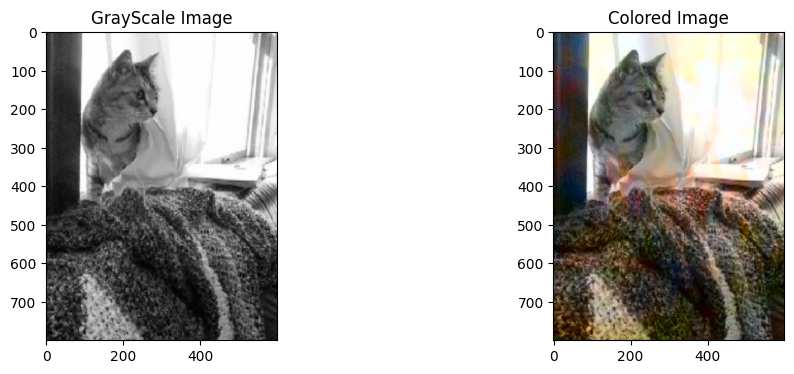

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.title("GrayScale Image")
plt.imshow(gray_img)

plt.subplot(1, 2, 2)
plt.title("Colored Image")
plt.imshow(color_img)

plt.show()

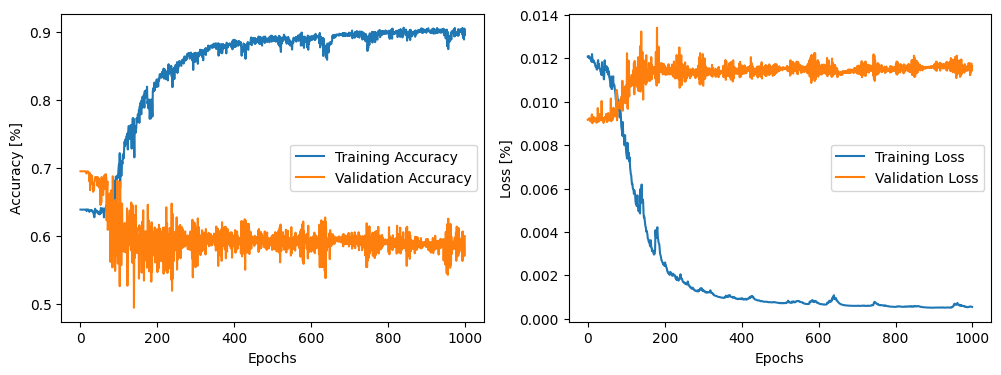

In [ ]:
# Plot the training and validation accuracy and loss
plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy [%]')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss [%]')
plt.legend()

plt.show()

# For Deploy


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od
import pandas

od.download("https://www.kaggle.com/datasets/aayush9753/image-colorization-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: benngki
Your Kaggle Key: ··········


100%|██████████| 473M/473M [00:06<00:00, 80.3MB/s]


In [ ]:
import skimage, keras

In [ ]:
print("tf="+tf.__version__)
print("cv2="+cv2.__version__)
print("np="+np.__version__)

print("skimage="+skimage.__version__)
print("keras="+keras.__version__)

tf=2.15.0
cv2=4.8.0
np=1.23.5
skimage=0.19.3
keras=2.15.0


In [ ]:
import tensorflow as tf
from tensorflow import keras
import cv2
import numpy as np
import matplotlib.pyplot as plt

from skimage.transform import resize
from skimage.color import rgb2lab, lab2rgb
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img

MODEL_PATH = "/content/drive/MyDrive/models/tf"
TEST_PATH = "/content/image-colorization-dataset/data"
TEST_PATH = "/content/c"
IMAGE_SIZE = (224, 224)

# Load Model
model = keras.models.load_model(MODEL_PATH)

def predict(output_dir):
  # Load and preprocessing the test images
  test_dir = TEST_PATH

  #Resize images
  img_width = 224
  img_height = 224
  image_size = (img_width, img_height)

  test_datagen = ImageDataGenerator(
          rescale=1./255,
          )

  test = test_datagen.flow_from_directory(batch_size=128,
                                                      directory=test_dir,
                                                      target_size=image_size,
                                                        color_mode = 'rgb',
                                                      class_mode=None)

  #Convert to LAB
  test_img = []
  for img in test[0]:
    try:
      lab = rgb2lab(img)
      test_img.append(lab[:,:,0])
    except:
      print('error')
  test_img = np.array(test_img)

  test_img = test_img.reshape(test_img.shape+(1,)) #dimensions to be the same for test_img

  grayscale = np.zeros((224, 224, 3))
  grayscale[:,:,0] = test_img[0][:,:,0]
  grayscale = resize(grayscale, (800,600))
  gray_img = lab2rgb(grayscale)

  output1 = model.predict(test_img)
  output1 = output1*128

  result = np.zeros((224, 224, 3))
  result[:,:,0] = test_img[0][:,:,0]
  result[:,:,1:] = output1[0]
  result = resize(result, (800,600))
  color_img = lab2rgb(result)

  # save image result
  color_img = array_to_img(color_img)
  color_img.save(output_dir+"result.jpg")

1/1 [==============================] - 0s 58ms/step


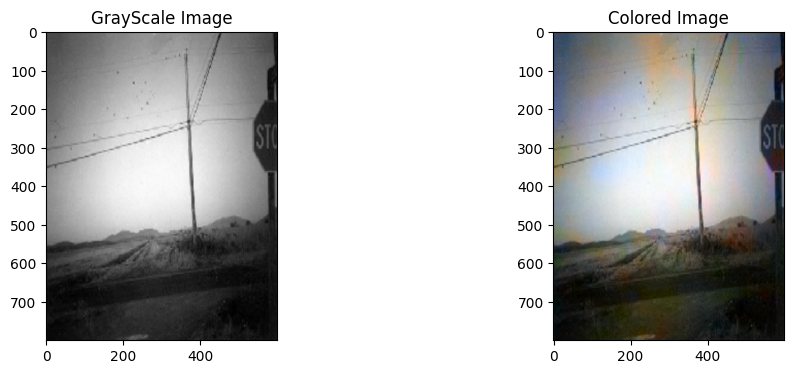

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.title("GrayScale Image")
plt.imshow(gray_img)

plt.subplot(1, 2, 2)
plt.title("Colored Image")
plt.imshow(color_img)

plt.show()

In [ ]:
img = cv2.imread("/content/image-colorization-dataset/data/test_black/image5001.jpg", cv2.COLOR_RGB2LAB)
img = cv2.resize(img, (IMAGE_SIZE))
img = img / 255

plt.imshow(img)

# grayscale = np.zeros((224, 224, 3))
# grayscale[:,:,0] = test_img[12][:,:,0]
# grayscale = resize(grayscale, (800,600))
# gray_img = lab2rgb(grayscale)

# output1 = model.predict(test_img)
# output1 = output1*128

# result = np.zeros((224, 224, 3))
# result[:,:,0] = test_img[12][:,:,0]
# result[:,:,1:] = output1[0]
# result = resize(result, (800,600))
# color_img = lab2rgb(result)

# titles = ['Grayscale Image', 'Colored Image']
# images = [gray_img, color_img]